In [10]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.linalg import SparseVector
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import col, row_number, to_date, count, percentile_approx, desc, udf, collect_set, array_contains, lit, last
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, DoubleType, ArrayType, NumericType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import regexp_extract, regexp_replace, when, trim, initcap, round, lower, split, explode, array_distinct, array_sort, concat_ws, expr

import utils.feature_store_bronze_table
import utils.feature_store_silver_table
import utils.feature_store_gold_table

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/13 04:14:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

In [5]:
# connect to source back end - IRL connect to back end source system
csv_file_path = "data/feature_clickstream.csv"

# load data - IRL ingest from back end source system
clickstream_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [6]:
clickstream_df.show(3)

+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Customer_ID|snapshot_date|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
|  63| 118|  80| 121|  55| 193| 111| 112|-101|   83|  164|  105|  -16|  -81| -126|  114|   35|   85|  -73|   76| CUS_0x1037|   2023-01-01|
|-108| 182| 123|   4| -56|  27|  25|  -6| 284|  222|  203|  190|  -14|  -96|  200|   35|  130|   94|  111|   75| CUS_0x1069|   2023-01-01|
| -13|   8|  87| 166| 214| -98| 215| 152| 129|  139|   14|  203|   26|   86|  171|  125| -130|  354|   17|  302| CUS_0x114a|   2023-01-01|
+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----------+-------------+
only showing top 3 rows



In [7]:
# connect to source back end - IRL connect to back end source system
csv_file_path = "data/features_attributes.csv"

# load data - IRL ingest from back end source system
attribute_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [8]:
# connect to source back end - IRL connect to back end source system
csv_file_path = "data/features_financials.csv"

# load data - IRL ingest from back end source system
financial_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [9]:
# Left Join on Customer_ID and snapshot_date
features_df = clickstream_df.join(attribute_df, on=['Customer_ID', 'snapshot_date'], how='outer')
features_df = features_df.join(financial_df, on=['Customer_ID', 'snapshot_date'], how='outer')

In [10]:
features_df.show(5)

[Stage 12:===>                                                    (1 + 15) / 16]

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Name| Age| SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_mon

In [11]:
features_df.count()

218902

In [12]:
len(features_df.columns)

46

In [13]:
# Check for missing (null) values in each column
null_counts = features_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in features_df.columns])
null_counts.show()

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|  Name|   Age|   SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total

### Clean clickstream

In [14]:
# List of columns to impute
columns_to_impute = [f"fe_{i}" for i in range(1, 21)]

# Compute medians for each column
medians = {
    col_name: features_df.approxQuantile(col_name, [0.5], 0.01)[0]
    for col_name in columns_to_impute
}

# Apply median imputation
for col_name in columns_to_impute:
    median_value = medians[col_name]
    features_df = features_df.withColumn(
        col_name,
        when(col(col_name).isNull(), median_value).otherwise(col(col_name))
    )

In [15]:
df_cleaned = features_df

In [16]:
# Check for missing (null) values in each column
null_counts = df_cleaned.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
null_counts.show()

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|  Name|   Age|   SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total

### Clean up features_attributes (name, age, SSN, Occupation) for EDA

In [17]:
# 1. Clean Age: Extract digits and cast to Integer
df_cleaned = df_cleaned.withColumn(
    "Age",
    regexp_extract(col("Age"), r"(\d+)", 1).cast(IntegerType())
)

# 2. Clean SSN: Match valid SSNs, else null
valid_ssn_pattern = r"^\d{3}-\d{2}-\d{4}$"
df_cleaned = df_cleaned.withColumn(
    "SSN",
    when(col("SSN").rlike(valid_ssn_pattern), col("SSN")).otherwise(None)
)

# 3. Clean Occupation: Remove placeholder, null if empty or invalid
df_cleaned = df_cleaned.withColumn(
    "Occupation",
    when((trim(col("Occupation")) == "") | (col("Occupation") == "_______"), None)
    .otherwise(initcap(regexp_replace(col("Occupation"), "_", " ")))  # Optional: beautify names
)

In [18]:
# Define the window partitioned by customer_id and ordered by snapshot_date
w = Window.partitionBy("customer_id").orderBy("snapshot_date").rowsBetween(Window.unboundedPreceding, 0)

# Apply last() with ignoreNulls=True to forward-fill values
df_cleaned = df_cleaned.withColumn("Age", last("Age", ignorenulls=True).over(w)) \
              .withColumn("SSN", last("SSN", ignorenulls=True).over(w)) \
              .withColumn("Occupation", last("Occupation", ignorenulls=True).over(w))

In [19]:
# Impute missing values with 'unknown' (cast numeric to string if needed)
df_cleaned = df_cleaned.fillna({'SSN': 'Unknown', 'Occupation': 'Unknown'})

In [20]:
# Compute median of Age (excluding nulls)
median_age = df_cleaned.approxQuantile("Age", [0.5], 0.01)[0]

df_cleaned = df_cleaned.fillna({"Age": median_age})

In [21]:
# Ensure snapshot_date is timestamp (if it's not already)
df_cleaned = df_cleaned.withColumn("snapshot_date", F.col("snapshot_date").cast("timestamp"))

# Define a window to get the latest non-null Name per Customer_ID
w = Window.partitionBy("Customer_ID").orderBy(F.col("snapshot_date").desc())

# Get latest non-null Name
df_cleaned = df_cleaned.withColumn(
    "latest_name",
    F.first("Name", ignorenulls=True).over(w)
)

# Fill Name column with latest if null, otherwise keep original
df_cleaned = df_cleaned.withColumn(
    "Name_filled",
    F.when(F.col("Name").isNull(), F.col("latest_name")).otherwise(F.col("Name"))
)

# Fill remaining nulls (if customer had no name at all) with 'Unknown'
df_cleaned = df_cleaned.withColumn(
    "Name_filled",
    F.when(F.col("Name_filled").isNull(), F.lit("Unknown")).otherwise(F.col("Name_filled"))
)

# Replace original Name column
df_cleaned = df_cleaned.drop("Name", "latest_name").withColumnRenamed("Name_filled", "Name")

In [22]:
# Check for missing (null) values in each column
null_counts = df_cleaned.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
null_counts.show()

[Stage 322:=================>                                     (5 + 11) / 16]

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+----+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount

### Clean cols in features_financials

In [23]:
# Clean annual income
# Remove non-numeric characters
df_cleaned = df_cleaned.withColumn(
    "Annual_Income",
    regexp_replace(col("Annual_Income"), r"[^\d.]", "")
    .cast("double")  # or "decimal(10,2)" for stricter typing
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn("Annual_Income", round(col("Annual_Income"), 2))

In [24]:
# Monthly_Inhand_Salary
# Clean non-numeric characters (keep digits and dot)
df_cleaned = df_cleaned.withColumn(
    "Monthly_Inhand_Salary",
    regexp_replace(col("Monthly_Inhand_Salary"), r"[^\d.]", "").cast("double")
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn(
    "Monthly_Inhand_Salary",
    round(col("Monthly_Inhand_Salary"), 2)
)

In [25]:
# Clean Num_Bank_Accounts
# Convert to integer and handle invalid values
df_cleaned = df_cleaned.withColumn(
    "Num_Bank_Accounts",
    when(col("Num_Bank_Accounts").cast("int") < 0, None)  # Set negative values to null
    .otherwise(col("Num_Bank_Accounts").cast("int"))
)

In [26]:
# Clean Num_of_Loan
# Remove non-digit characters and cast to integer
df_cleaned = df_cleaned.withColumn(
    "Num_of_Loan",
    regexp_replace(col("Num_of_Loan"), r"[^\d\-]", "").cast("int")
)

# Replace invalid values (e.g. negative loans) with null
df_cleaned = df_cleaned.withColumn(
    "Num_of_Loan",
    when(col("Num_of_Loan") < 0, None).otherwise(col("Num_of_Loan"))
)

In [27]:
# forward fill
categorical_cols = ['Type_of_Loan']

# Define window spec for forward fill
w = Window.partitionBy("customer_id").orderBy("snapshot_date").rowsBetween(Window.unboundedPreceding, 0)

# Forward fill each numerical column
for col_name in categorical_cols:
    df_cleaned = df_cleaned.withColumn(col_name, last(col_name, ignorenulls=True).over(w))

In [28]:
# Clean up type of loan and split them nicely
# 1. Fill null or empty strings with "Not_Specified"
df_cleaned = df_cleaned.fillna("Not Specified", subset=["Type_of_Loan"])

# Replace empty strings in 'Type_of_Loan' with 'Not Specified'
df_cleaned = df_cleaned.withColumn(
    "Type_of_Loan",
    when(trim(col("Type_of_Loan")) == "", "Not Specified").otherwise(col("Type_of_Loan"))
)

In [29]:
# Step 1: Clean and standardize the loan types
df_cleaned = df_cleaned.withColumn(
    "cleaned_loans",
    F.regexp_replace(
        F.lower(F.col("Type_of_Loan")),
        "(\s+and\s+)|(,\s+and\s+)|(,\s*)",  # Standardize all separators
        ","  # Replace with simple comma
    )
)

# Step 2: Split into array and trim whitespace
df_cleaned = df_cleaned.withColumn(
    "loan_array",
    F.expr("transform(split(cleaned_loans, ','), x -> trim(x))")
)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2006/1292790305.py:6: SyntaxWarning: invalid escape sequence '\s'
  "(\s+and\s+)|(,\s+and\s+)|(,\s*)",  # Standardize all separators


In [30]:
df_cleaned.count()

218902

In [31]:
# Delay_from_due_date
# Cast to integer and replace negative delays with null
df_cleaned = df_cleaned.withColumn(
    "Delay_from_due_date",
    when(col("Delay_from_due_date").cast("int") < 0, None)
    .otherwise(col("Delay_from_due_date").cast("int"))
)

In [32]:
# Clean Num_of_Delayed_Payment
# Remove non-digit characters and cast to integer
df_cleaned = df_cleaned.withColumn(
    "Num_of_Delayed_Payment",
    regexp_replace(col("Num_of_Delayed_Payment"), r"[^\d\-]", "").cast("int")
)

# Replace invalid values (e.g. negative loans) with null
df_cleaned = df_cleaned.withColumn(
    "Num_of_Delayed_Payment",
    when(col("Num_of_Delayed_Payment") < 0, None).otherwise(col("Num_of_Delayed_Payment"))
)

In [33]:
# Changed_Credit_Limit
df_cleaned = df_cleaned.withColumn(
    "Changed_Credit_Limit",
    regexp_replace(col("Changed_Credit_Limit"), r"[^\d\.-]", "").cast("double")
)

df_cleaned = df_cleaned.withColumn(
    "Changed_Credit_Limit",
    round(col("Changed_Credit_Limit"), 2)
)

In [34]:
# Num_Credit_Inquiries
# Cast to integer and replace negative delays with null
df_cleaned = df_cleaned.withColumn(
    "Num_Credit_Inquiries",
    when(col("Num_Credit_Inquiries").cast("int") < 0, None)
    .otherwise(col("Num_Credit_Inquiries").cast("int"))
)

In [35]:
# Credit_Mix
df_cleaned = df_cleaned.withColumn(
    "Credit_Mix",
    when(trim(col("Credit_Mix")) == "_", None)  # Replace "_" with null
    .otherwise(initcap(trim(col("Credit_Mix"))))  # Standardize casing
)

In [36]:
# Outstanding_Debt
# Clean non-numeric characters (keep digits and dot)
df_cleaned = df_cleaned.withColumn(
    "Outstanding_Debt",
    regexp_replace(col("Outstanding_Debt"), r"[^\d.]", "").cast("double")
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn(
    "Outstanding_Debt",
    round(col("Outstanding_Debt"), 2)
)

In [37]:
# Credit_Utilization_Ratio
# Clean non-numeric characters (keep digits and dot)
df_cleaned = df_cleaned.withColumn(
    "Credit_Utilization_Ratio",
    regexp_replace(col("Credit_Utilization_Ratio"), r"[^\d.]", "").cast("double")
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn(
    "Credit_Utilization_Ratio",
    round(col("Credit_Utilization_Ratio"), 2)
)

In [38]:
# Credit_History_Age
# Extract years and months using regex
df_cleaned = df_cleaned.withColumn("Years", regexp_extract(col("Credit_History_Age"), r"(\d+)\s+Years", 1).cast("int")) \
               .withColumn("Months", regexp_extract(col("Credit_History_Age"), r"(\d+)\s+Months", 1).cast("int"))

# Convert to float years: years + (months / 12), rounded to 2 decimals
df_cleaned = df_cleaned.withColumn(
    "Credit_History_Age",
    round(col("Years") + (col("Months") / 12), 2)
)

# Drop intermediate columns if desired
df_cleaned = df_cleaned.drop("Years", "Months")

In [39]:
# Payment_of_Min_Amount
# Clean and standardize
df_cleaned = df_cleaned.withColumn(
    "Payment_of_Min_Amount",
    when(trim(lower(col("Payment_of_Min_Amount"))) == "yes", "Yes")
    .when(trim(lower(col("Payment_of_Min_Amount"))) == "no", "No")
    .otherwise(None)  # Replace NM or any unexpected values with null
)


In [40]:
# Total_EMI_per_month
# Clean non-numeric characters (keep digits and dot)
df_cleaned = df_cleaned.withColumn(
    "Total_EMI_per_month",
    regexp_replace(col("Total_EMI_per_month"), r"[^\d.]", "").cast("double")
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn(
    "Total_EMI_per_month",
    round(col("Total_EMI_per_month"), 2)
)

In [41]:
# Amount_invested_monthly
# Clean non-numeric characters (keep digits and dot)
df_cleaned = df_cleaned.withColumn(
    "Amount_invested_monthly",
    regexp_replace(col("Amount_invested_monthly"), r"[^\d.]", "").cast("double")
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn(
    "Amount_invested_monthly",
    round(col("Amount_invested_monthly"), 2)
)

In [42]:
# Payment_Behaviour
# Define valid patterns 
valid_pattern = r"^(High|Low)_spent_(Small|Medium)_value_payments$"

# Clean Payment_Behaviour
df_cleaned = df_cleaned.withColumn(
    "Payment_Behaviour",
    when(col("Payment_Behaviour").rlike(valid_pattern), col("Payment_Behaviour"))
    .otherwise(None)  # Set invalid values to null
)

In [43]:
# Monthly_Balance
# Clean non-numeric characters (keep digits and dot)
df_cleaned = df_cleaned.withColumn(
    "Monthly_Balance",
    regexp_replace(col("Monthly_Balance"), r"[^\d.]", "").cast("double")
)

# Round to 2 decimal places
df_cleaned = df_cleaned.withColumn(
    "Monthly_Balance",
    round(col("Monthly_Balance"), 2)
)

In [44]:
df_cleaned.show(3)

[Stage 357:===>                                                   (1 + 15) / 16]

+-----------+-------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------+-------------+---------------+
|Customer_ID|      snapshot_date| fe_1| fe_2| fe_3| fe_4| fe_5| fe_6| fe_7| fe_8| fe_9| fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Age|    SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan| Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization

In [45]:
df_cleaned.count()

218902

In [46]:
# Check for missing (null) values in each column
null_counts = df_cleaned.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
null_counts.show()

[Stage 397:==========>                                            (3 + 13) / 16]

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+----+-------------+----------+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|T

### Foward fill numerical cols else impute with median

In [47]:
numerical_cols = [
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Credit_History_Age',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

# Define window spec for forward fill
w = Window.partitionBy("customer_id").orderBy("snapshot_date").rowsBetween(Window.unboundedPreceding, 0)

# Forward fill each numerical column
for col_name in numerical_cols:
    df_cleaned = df_cleaned.withColumn(col_name, last(col_name, ignorenulls=True).over(w))

In [48]:
# Columns to impute
cols_to_impute = [
    'Annual_Income',
    'Monthly_Inhand_Salary',
    'Num_Bank_Accounts',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_of_Loan',
    'Delay_from_due_date',
    'Num_of_Delayed_Payment',
    'Changed_Credit_Limit',
    'Num_Credit_Inquiries',
    'Outstanding_Debt',
    'Credit_Utilization_Ratio',
    'Credit_History_Age',
    'Total_EMI_per_month',
    'Amount_invested_monthly',
    'Monthly_Balance'
]

# Calculate medians using approxQuantile
medians = {
    col_name: df_cleaned.approxQuantile(col_name, [0.5], 0.01)[0]
    for col_name in cols_to_impute
}

# Impute missing values with median
for col_name in cols_to_impute:
    median_value = medians[col_name]
    df_cleaned = df_cleaned.withColumn(
        col_name,
        when(col(col_name).isNull(), median_value).otherwise(col(col_name))
    )

In [49]:
# Check for missing (null) values in each column
null_counts = df_cleaned.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
null_counts.show()

[Stage 693:>                                                      (0 + 16) / 16]

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+----+-------------+----------+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|T

In [50]:
# forward fill
categorical_cols = ['Credit_Mix', 'Payment_Behaviour']

# Define window spec for forward fill
w = Window.partitionBy("customer_id").orderBy("snapshot_date").rowsBetween(Window.unboundedPreceding, 0)

# Forward fill each numerical column
for col_name in categorical_cols:
    df_cleaned = df_cleaned.withColumn(col_name, last(col_name, ignorenulls=True).over(w))

In [51]:
# Categorical columns to impute with "Unknown"
categorical_cols = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

# Impute missing (null) values with "Unknown"
for col_name in categorical_cols:
    df_cleaned = df_cleaned.withColumn(
        col_name,
        when(col(col_name).isNull(), "Unknown").otherwise(col(col_name))
    )

In [52]:
# Check for missing (null) values in each column
null_counts = df_cleaned.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_cleaned.columns])
null_counts.show()

[Stage 717:========================>                               (7 + 9) / 16]

+-----------+-------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+----+-------------+----------+
|Customer_ID|snapshot_date|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|T

In [53]:
df_cleaned.count()

218902

### EDA

In [184]:
# # Get only latest snapshot for EDA
# # Ensure snapshot_date is in date format
# latest_features_df = df_cleaned.withColumn("snapshot_date", to_date("snapshot_date", "yyyy-MM-dd"))

# # Define a window partitioned by Customer_ID, ordered by snapshot_date descending
# window_spec = Window.partitionBy("Customer_ID").orderBy(col("snapshot_date").desc())

# # Add row_number to rank records
# ranked_df = latest_features_df.withColumn("rn", row_number().over(window_spec))

# # Filter only latest records (row_number == 1)
# latest_features_df = ranked_df.filter(col("rn") == 1).drop("rn")

In [185]:
# latest_features_df.show(5)

In [186]:
# # OR using where
# df_filtered = latest_features_df.where(col("customer_id") == "CUS_0x1037")

# # Show the result
# df_filtered.show()

In [54]:
#get label store data
gold_label_store_directory = "datamart/gold/label_store/"

folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
labels_df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",labels_df.count())

row_count: 8974


In [55]:
labels_df.show(3)

+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 3 rows



In [56]:
# Left Join on Customer_ID and snapshot_date
eda_df = labels_df.join(df_cleaned, on=['Customer_ID', 'snapshot_date'], how='left')

In [57]:
eda_df.show(3)

[Stage 764:========================>                               (7 + 9) / 16]

+-----------+-------------+--------------------+-----+----------+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+------+-----+-----+-----+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+---------------+-------+--------------------+--------------------+
|Customer_ID|snapshot_date|             loan_id|label| label_def| fe_1| fe_2|  fe_3| fe_4| fe_5| fe_6| fe_7| fe_8| fe_9|fe_10|fe_11|fe_12| fe_13|fe_14|fe_15|fe_16| fe_17|fe_18|fe_19|fe_20| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num

In [58]:
# Check for missing (null) values in each column
null_counts = eda_df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in eda_df.columns])
null_counts.show()

[Stage 798:=========================================>             (12 + 4) / 16]

+-----------+-------------+-------+-----+---------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+----+-------------+----------+
|Customer_ID|snapshot_date|loan_id|label|label_def|fe_1|fe_2|fe_3|fe_4|fe_5|fe_6|fe_7|fe_8|fe_9|fe_10|fe_11|fe_12|fe_13|fe_14|fe_15|fe_16|fe_17|fe_18|fe_19|fe_20|Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_

In [59]:
eda_df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- loan_id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- fe_1: double (nullable = true)
 |-- fe_2: double (nullable = true)
 |-- fe_3: double (nullable = true)
 |-- fe_4: double (nullable = true)
 |-- fe_5: double (nullable = true)
 |-- fe_6: double (nullable = true)
 |-- fe_7: double (nullable = true)
 |-- fe_8: double (nullable = true)
 |-- fe_9: double (nullable = true)
 |-- fe_10: double (nullable = true)
 |-- fe_11: double (nullable = true)
 |-- fe_12: double (nullable = true)
 |-- fe_13: double (nullable = true)
 |-- fe_14: double (nullable = true)
 |-- fe_15: double (nullable = true)
 |-- fe_16: double (nullable = true)
 |-- fe_17: double (nullable = true)
 |-- fe_18: double (nullable = true)
 |-- fe_19: double (nullable = true)
 |-- fe_20: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SSN: string (nullab

In [60]:
# Get numerical columns
numeric_cols = [field.name for field in eda_df.schema.fields if isinstance(field.dataType, NumericType)]

print("Numeric columns:", numeric_cols)

Numeric columns: ['label', 'fe_1', 'fe_2', 'fe_3', 'fe_4', 'fe_5', 'fe_6', 'fe_7', 'fe_8', 'fe_9', 'fe_10', 'fe_11', 'fe_12', 'fe_13', 'fe_14', 'fe_15', 'fe_16', 'fe_17', 'fe_18', 'fe_19', 'fe_20', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


In [61]:
from pyspark.sql.types import NumericType

# Replace this with your actual binary label column name
binary_label_col = 'label'

# Ensure the binary label column exists
if binary_label_col not in eda_df.columns:
    raise ValueError(f"Binary label column '{binary_label_col}' not found in DataFrame.")

# Get all numeric columns
numeric_cols = [f.name for f in eda_df.schema.fields if isinstance(f.dataType, NumericType)][1:]

# Include the label for plotting
cols_to_plot = numeric_cols + [binary_label_col]

# Select subset for plotting
df_subset = eda_df.select(*cols_to_plot)

In [62]:
pdf = df_subset.toPandas()

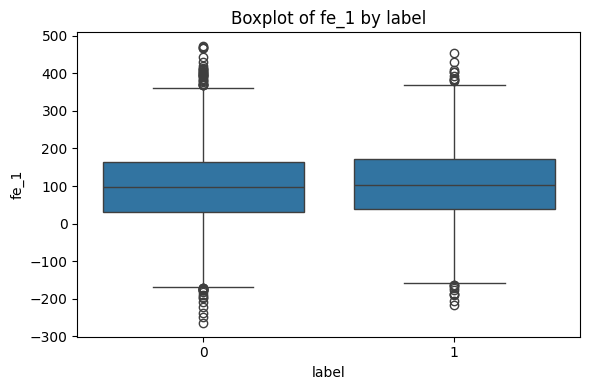

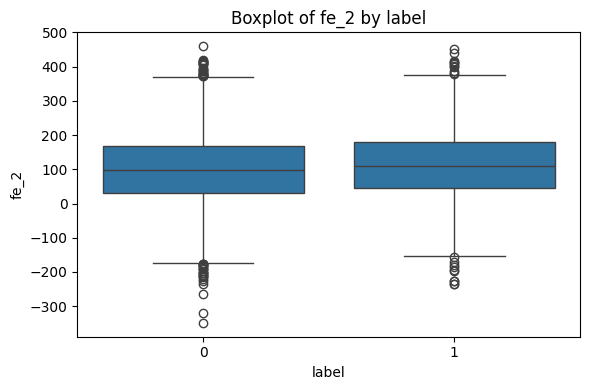

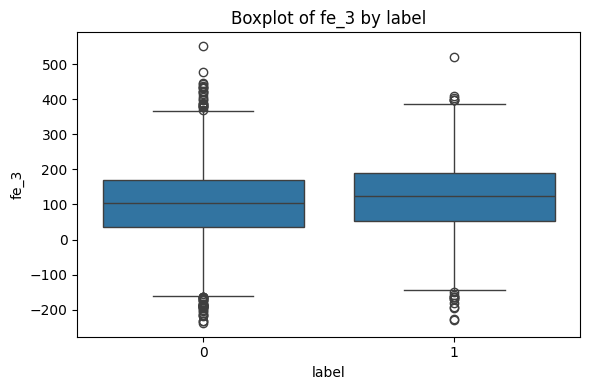

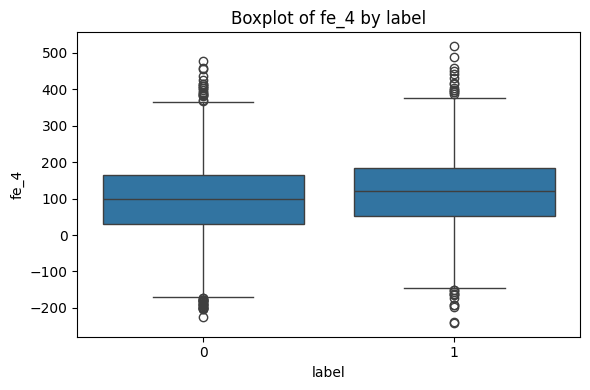

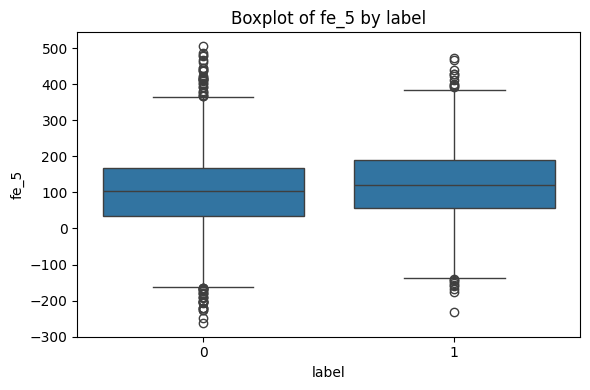

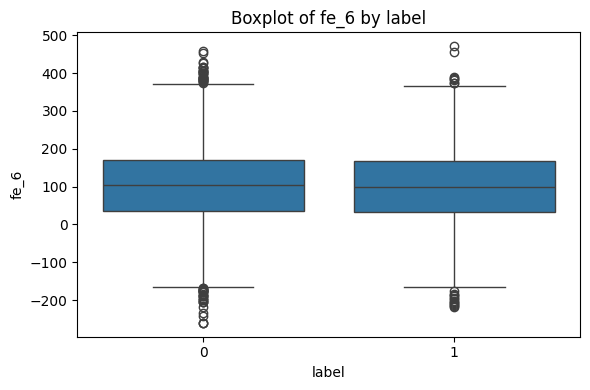

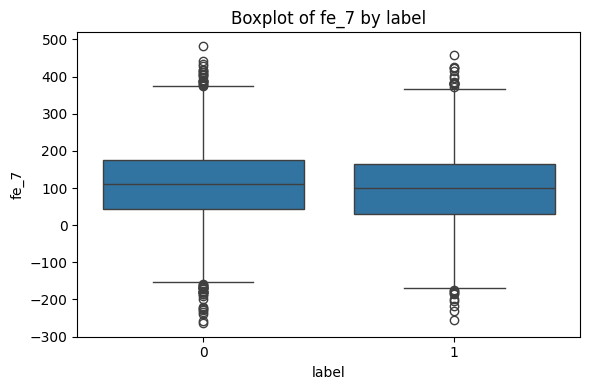

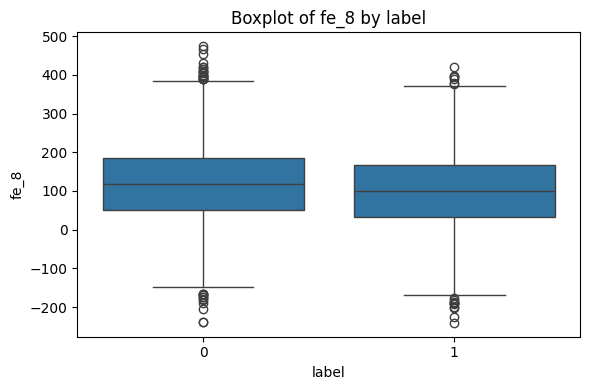

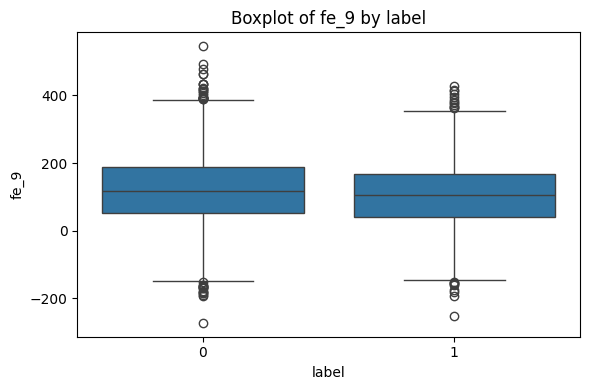

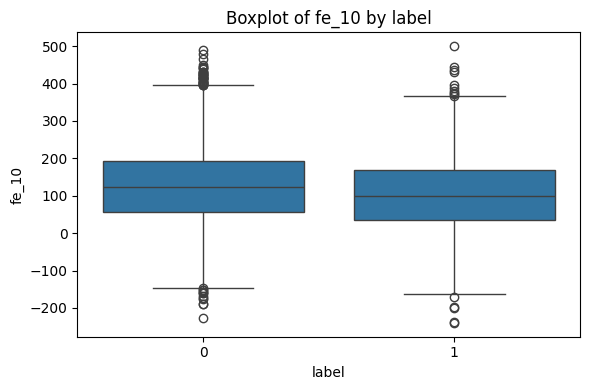

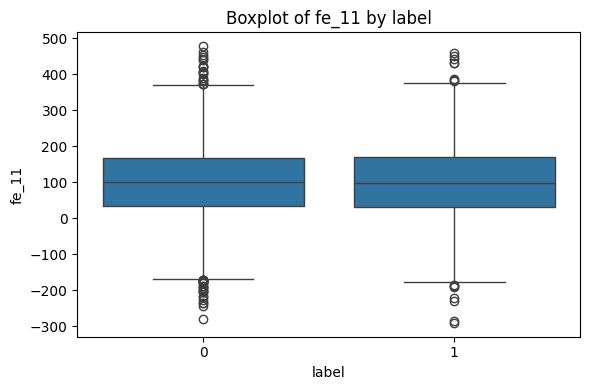

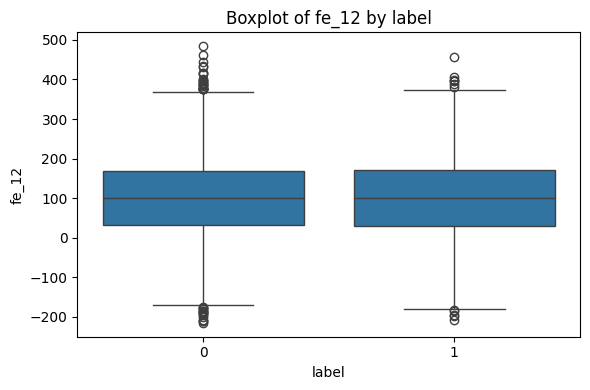

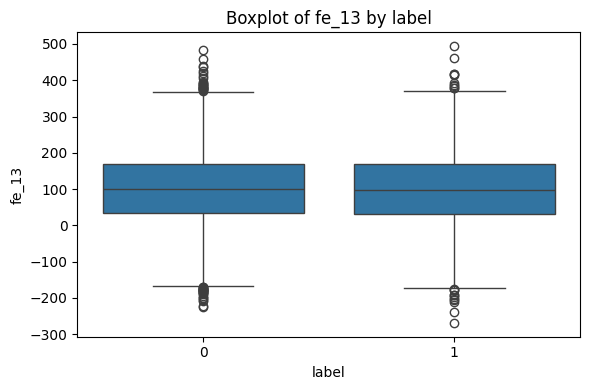

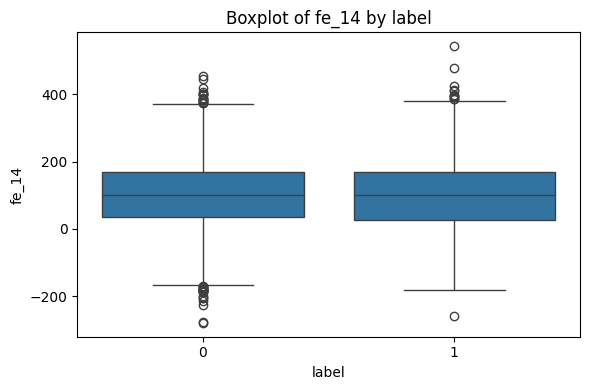

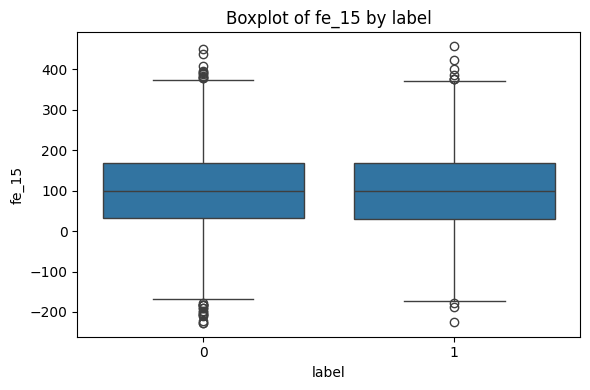

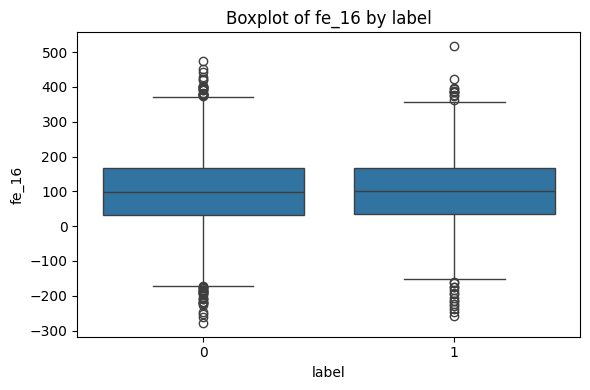

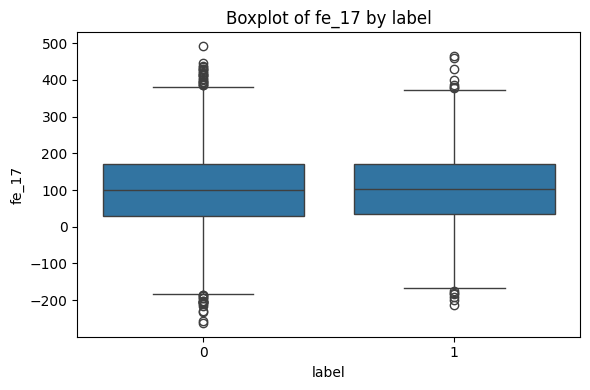

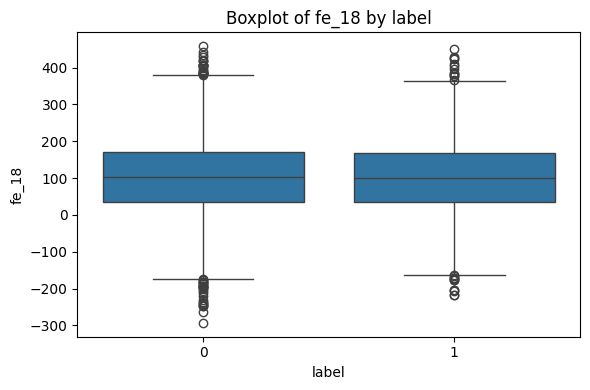

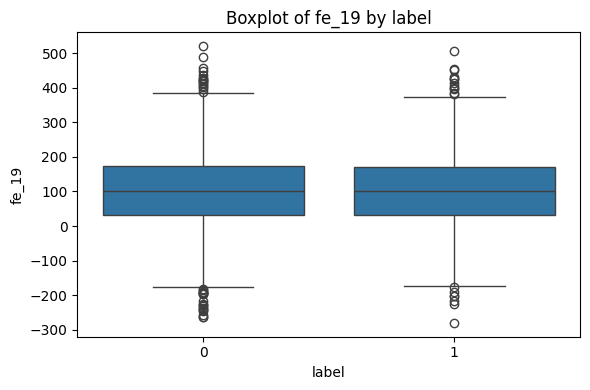

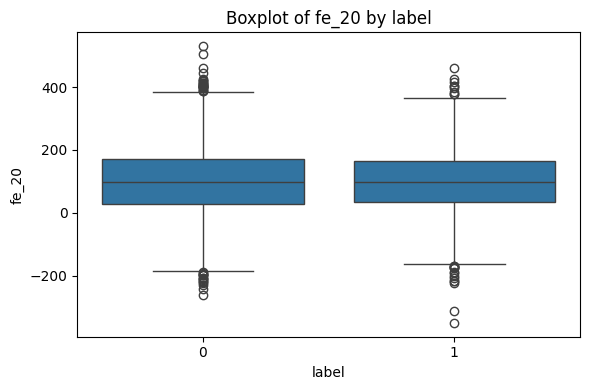

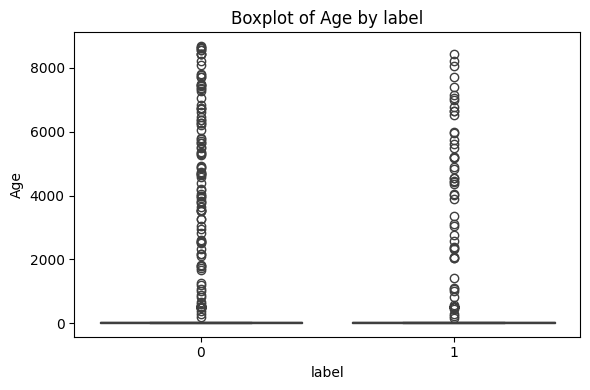

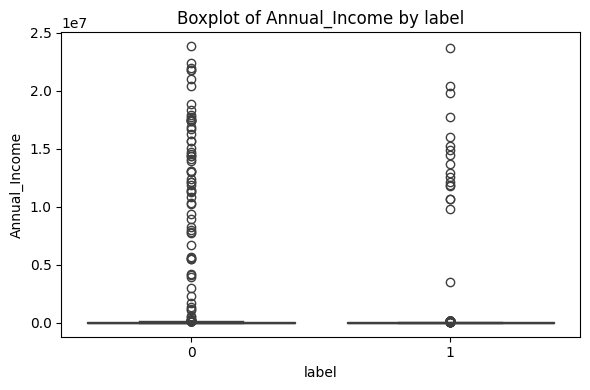

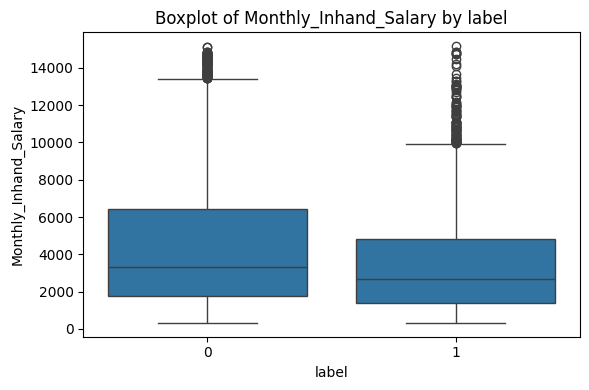

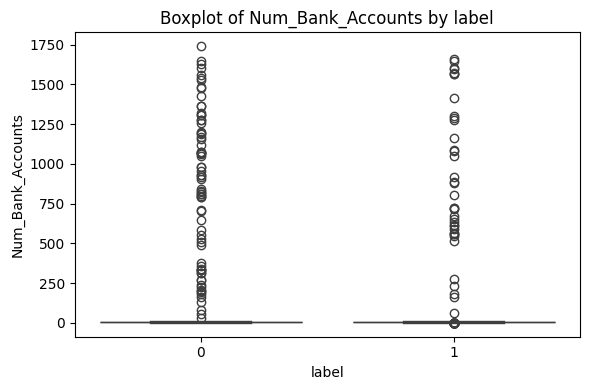

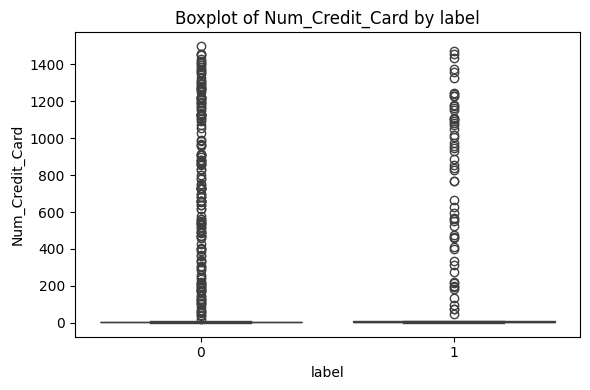

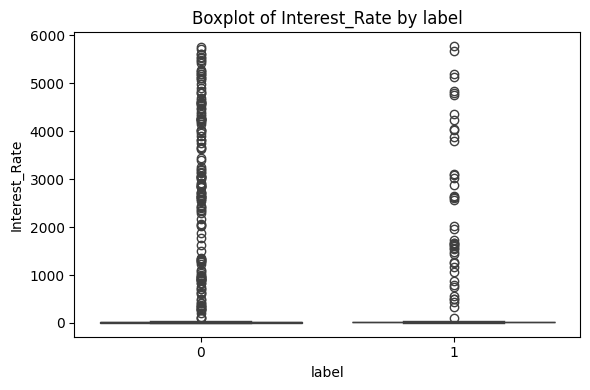

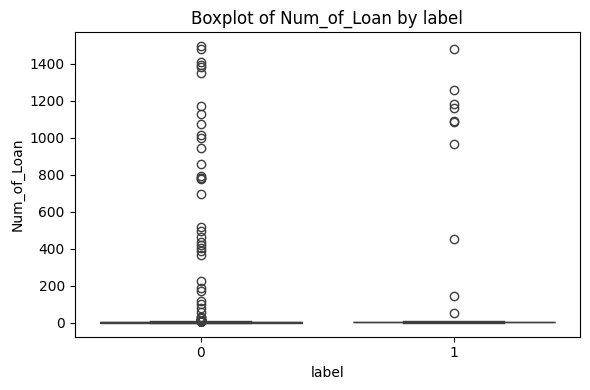

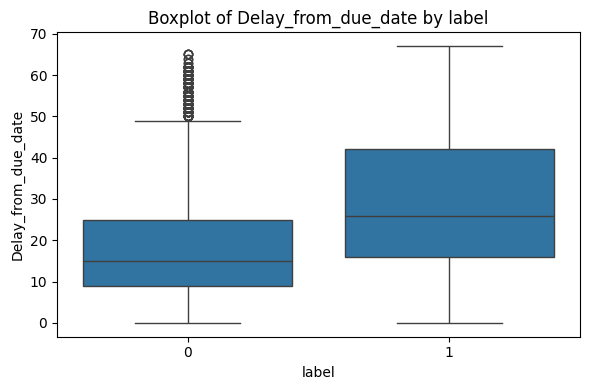

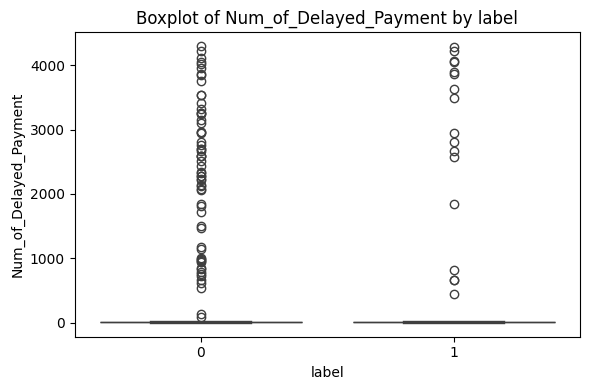

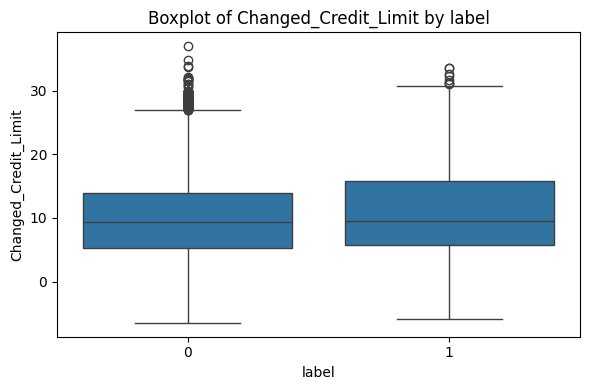

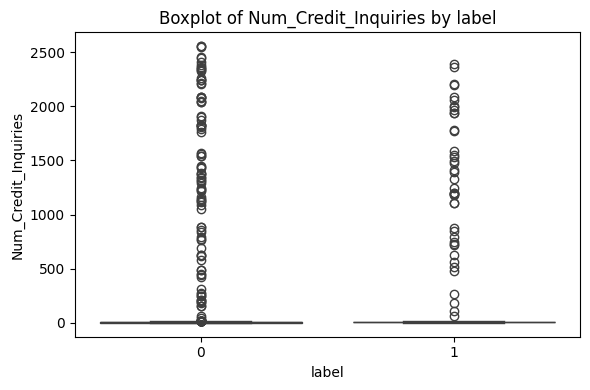

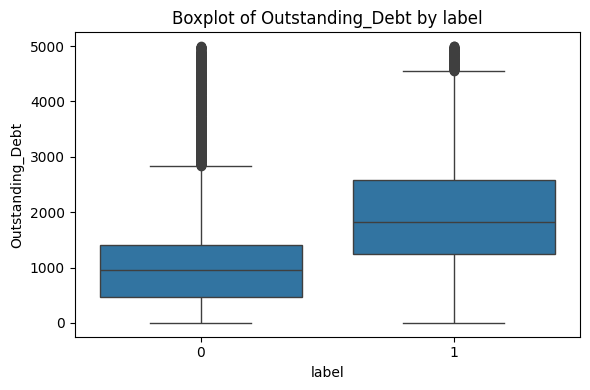

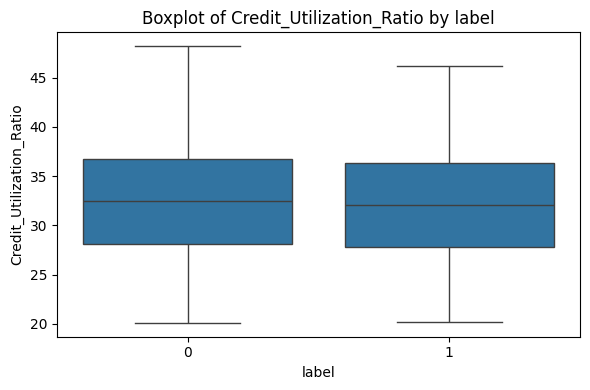

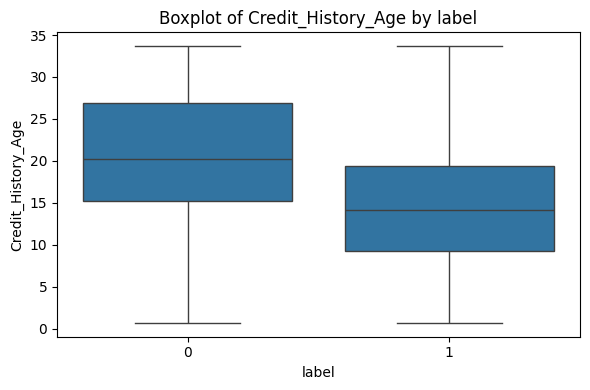

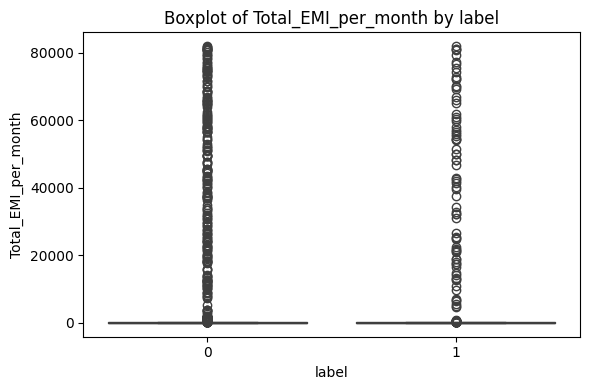

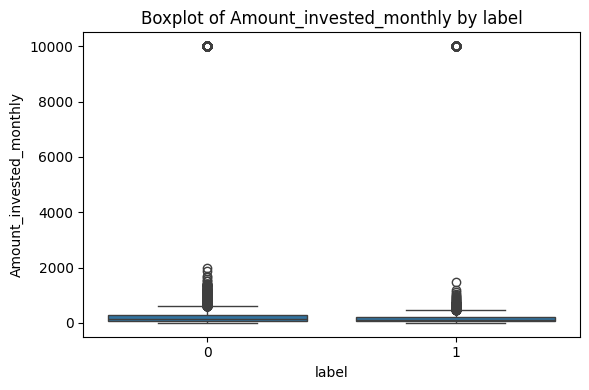

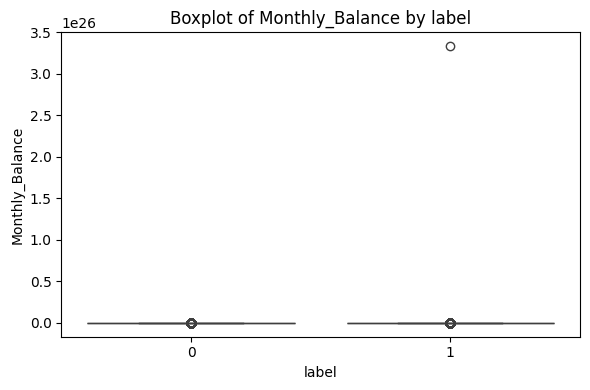

In [63]:
# Loop through numeric columns and plot
for num_col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='label', y=num_col, data=pdf)
    plt.title(f'Boxplot of {num_col} by label')
    plt.tight_layout()
    plt.show()
    plt.close('all')

### Enforce schema

In [64]:
column_type_map = {
    'Customer_ID': StringType(),
 'snapshot_date': DateType(),
 'fe_1': DoubleType(),
 'fe_2': DoubleType(),
 'fe_3': DoubleType(),
 'fe_4': DoubleType(),
 'fe_5': DoubleType(),
 'fe_6': DoubleType(),
 'fe_7': DoubleType(),
 'fe_8': DoubleType(),
 'fe_9': DoubleType(),
 'fe_10': DoubleType(),
 'fe_11': DoubleType(),
 'fe_12': DoubleType(),
 'fe_13': DoubleType(),
 'fe_14': DoubleType(),
 'fe_15': DoubleType(),
 'fe_16': DoubleType(),
 'fe_17': DoubleType(),
 'fe_18': DoubleType(),
 'fe_19': DoubleType(),
 'fe_20': DoubleType(),
 'Age': IntegerType(),
 'SSN': StringType(),
 'Occupation': StringType(),
 'Annual_Income': DoubleType(),
 'Monthly_Inhand_Salary': DoubleType(),
 'Num_Bank_Accounts': IntegerType(),
 'Num_Credit_Card': IntegerType(),
 'Interest_Rate': IntegerType(),
 'Num_of_Loan': IntegerType(),
 'Type_of_Loan': StringType(),
 'Delay_from_due_date': IntegerType(),
 'Num_of_Delayed_Payment': IntegerType(),
 'Changed_Credit_Limit': DoubleType(),
 'Num_Credit_Inquiries': IntegerType(),
 'Credit_Mix': StringType(),
 'Outstanding_Debt': DoubleType(),
 'Credit_Utilization_Ratio': DoubleType(),
 'Credit_History_Age': DoubleType(),
 'Payment_of_Min_Amount': StringType(),
 'Total_EMI_per_month': DoubleType(),
 'Amount_invested_monthly': DoubleType(),
 'Payment_Behaviour': StringType(),
 'Monthly_Balance': DoubleType(),
 'Name': StringType(),
 'cleaned_loans':StringType(),
 'loan_array': ArrayType(StringType())}

In [65]:
# Assuming df_cleaned is your input DataFrame
df_casted = df_cleaned
for column, new_type in column_type_map.items():
    if column in df_casted.columns:
        df_casted = df_casted.withColumn(column, col(column).cast(new_type))

In [66]:
df_casted.count()

218902

### OHE for gold table

In [67]:
# Index and encode
indexer = StringIndexer(inputCol="Occupation", outputCol="Occupation_Indexed", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="Occupation_Indexed", outputCol="Occupation_OHE")  # dropLast=True by default

pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(df_casted)
df_encoded = model.transform(df_casted)

# Get occupation labels
occupation_labels = model.stages[0].labels  # StringIndexer labels

#  Convert OHE vector to array
def vector_to_array(v):
    return v.toArray().tolist()

vec_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
df_encoded = df_encoded.withColumn("Occupation_OHE_Array", vec_to_array_udf(col("Occupation_OHE")))

# Create individual binary columns, but DROP the first category (index 0)
for i, label in enumerate(occupation_labels[1:], start=1):  # Skip first label
    col_name = f"Occupation_{label.replace(' ', '_')}"
    df_encoded = df_encoded.withColumn(col_name, col("Occupation_OHE_Array")[i - 1])  # Index i-1 due to dropped one

# Clean up intermediate columns
df_encoded = df_encoded.drop("Occupation_Indexed", "Occupation_OHE", "Occupation_OHE_Array", "Occupation")

In [68]:
df_encoded.count()

218902

In [69]:
# Index and encode
indexer = StringIndexer(inputCol="Credit_Mix", outputCol="Credit_Mix_Indexed", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="Credit_Mix_Indexed", outputCol="Credit_Mix_OHE")  # dropLast=True by default

pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)

# Get occupation labels
Credit_Mix_labels = model.stages[0].labels  # StringIndexer labels

#  Convert OHE vector to array
def vector_to_array(v):
    return v.toArray().tolist()

vec_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
df_encoded = df_encoded.withColumn("Credit_Mix_OHE_Array", vec_to_array_udf(col("Credit_Mix_OHE")))

# Create individual binary columns, but DROP the first category (index 0)
for i, label in enumerate(Credit_Mix_labels[1:], start=1):  # Skip first label
    col_name = f"Credit_Mix_{label.replace(' ', '_')}"
    df_encoded = df_encoded.withColumn(col_name, col("Credit_Mix_OHE_Array")[i - 1])  # Index i-1 due to dropped one

# Clean up intermediate columns
df_encoded = df_encoded.drop("Credit_Mix_Indexed", "Credit_Mix_OHE", "Credit_Mix_OHE_Array", "Credit_Mix")

In [70]:
df_encoded.count()

218902

In [71]:
# Index and encode
indexer = StringIndexer(inputCol="Payment_Behaviour", outputCol="Payment_Behaviour_Indexed", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="Payment_Behaviour_Indexed", outputCol="Payment_Behaviour_OHE")  # dropLast=True by default

pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)

# Get occupation labels
Payment_Behaviour_labels = model.stages[0].labels  # StringIndexer labels

#  Convert OHE vector to array
def vector_to_array(v):
    return v.toArray().tolist()

vec_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
df_encoded = df_encoded.withColumn("Payment_Behaviour_OHE_Array", vec_to_array_udf(col("Payment_Behaviour_OHE")))

# Create individual binary columns, but DROP the first category (index 0)
for i, label in enumerate(Payment_Behaviour_labels[1:], start=1):  # Skip first label
    col_name = f"Payment_Behaviour_{label.replace(' ', '_')}"
    df_encoded = df_encoded.withColumn(col_name, col("Payment_Behaviour_OHE_Array")[i - 1])  # Index i-1 due to dropped one

# Clean up intermediate columns
df_encoded = df_encoded.drop("Payment_Behaviour_Indexed", "Payment_Behaviour_OHE", "Payment_Behaviour_OHE_Array", "Payment_Behaviour")

In [72]:
df_encoded.count()

218902

In [73]:
# Index and encode
indexer = StringIndexer(inputCol="Payment_of_Min_Amount", outputCol="Payment_of_Min_Amount_Indexed", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="Payment_of_Min_Amount_Indexed", outputCol="Payment_of_Min_Amount_OHE")  # dropLast=True by default

pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(df_encoded)
df_encoded = model.transform(df_encoded)

# Get occupation labels
Payment_of_Min_Amount_labels = model.stages[0].labels  # StringIndexer labels

#  Convert OHE vector to array
def vector_to_array(v):
    return v.toArray().tolist()

vec_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))
df_encoded = df_encoded.withColumn("Payment_of_Min_Amount_OHE_Array", vec_to_array_udf(col("Payment_of_Min_Amount_OHE")))

# Create individual binary columns, but DROP the first category (index 0)
for i, label in enumerate(Payment_of_Min_Amount_labels[1:], start=1):  # Skip first label
    col_name = f"Payment_of_Min_Amount_{label.replace(' ', '_')}"
    df_encoded = df_encoded.withColumn(col_name, col("Payment_of_Min_Amount_OHE_Array")[i - 1])  # Index i-1 due to dropped one

# Clean up intermediate columns
df_encoded = df_encoded.drop("Payment_of_Min_Amount_Indexed", "Payment_of_Min_Amount_OHE", "Payment_of_Min_Amount_OHE_Array", "Payment_of_Min_Amount")

In [74]:
df_encoded.count()

218902

In [75]:
# Step 3: Get all unique loan types
all_loans = df_encoded.select(F.explode("loan_array").alias("loan_type")) \
              .distinct() \
              .collect()

loan_types = [row.loan_type for row in all_loans]

# Step 4: Create one-hot encoded columns
for loan in loan_types:
    col_name = loan.replace(" ", "_").replace("-", "_")
    df_encoded = df_encoded.withColumn(
        col_name,
        F.array_contains("loan_array", loan).cast("int")
    )

# Step 5: Clean up intermediate columns
df_encoded = df_encoded.drop("cleaned_loans", "loan_array","not_specified", "Type_of_Loan")

In [76]:
df_encoded.count()

218902

In [81]:
df_encoded.show(3)

[Stage 1141:>                                                       (0 + 1) / 1]

+-----------+-------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+------+-----------------+--------------------+-----------------+------------------------+--------------------+---------------------+-------------------+-------------------+---------------------+------------------+--------------------+-----------------------+-----------------+------------------+-------------------+-------------------+---------------+--------------+------------------------------------------------+--------------------------------------------------+-------------------------------------------------+----------------------

Left with Name and SSN with Unknowns (will be dropped later during training)

### Feature Engineer

In [84]:
# recent delay is > 10 days, else 0
df = df_encoded.withColumn(
    "Recent_Delays",
    when(col("Delay_from_due_date") > 10, 1).otherwise(0)
)

df = df.withColumn(
    "Income_to_Debt_Ratio",
    (col("Annual_Income") / col("Outstanding_Debt"))
)

df = df.withColumn(
    "EMI_to_Income_Ratio",
    (col("Total_EMI_per_month") / (col("Annual_Income") / 12))
)

df = df.withColumn(
    "Monthly_Saving",
    col("Monthly_Inhand_Salary") - col("Total_EMI_per_month") - col("Amount_invested_monthly")
)

# Add Num_Bank_Accounts + Num_Credit_Card and flag if above threshold
df = df.withColumn(
    "Is_Multi_Borrower",
    when((col("Num_Bank_Accounts") + col("Num_Credit_Card")) > 6, 1).otherwise(0)
)

#Int_across_loans
df = df.withColumn(
    "Int_across_loans",
    (col("Interest_Rate") / col("Num_of_Loan"))
)

#Delinquency_Score
df = df.withColumn(
    "Delinquency_Score",
    (col("Num_of_Delayed_Payment") / (col("Num_Credit_Card")+col("Num_of_Loan"))
))

# Round to 2dp
df = df.withColumn("Income_to_Debt_Ratio", round(col("Income_to_Debt_Ratio"), 2)) \
       .withColumn("EMI_to_Income_Ratio", round(col("EMI_to_Income_Ratio"), 2)) \
       .withColumn("Monthly_Saving", round(col("Monthly_Saving"), 2))

In [85]:
df.show(3)

+-----------+-------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+------+-----------------+--------------------+-----------------+------------------------+--------------------+---------------------+-------------------+-------------------+---------------------+------------------+--------------------+-----------------------+-----------------+------------------+-------------------+-------------------+---------------+--------------+------------------------------------------------+--------------------------------------------------+-------------------------------------------------+----------------------

In [86]:
df.count()

218902

In [5]:
# create bronze datalake
bronze_feature_store_directory = "datamart/bronze/feature_store/"

if not os.path.exists(bronze_feature_store_directory):
    os.makedirs(bronze_feature_store_directory)

In [89]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.feature_store_bronze_table.feature_store_bronze_table(date_str, bronze_feature_store_directory, spark)


2023-01-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_05_01.csv
2023-06-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_08_01.csv
2023-09-01row count: 8974
saved to: datamart/bronze/feature_store/bronze_feature_store_daily_2023_09_01.csv
2023-10-01row count: 8974
sa

In [6]:
# create silver datalake
silver_feature_store_directory = "datamart/silver/feature_store/"

if not os.path.exists(silver_feature_store_directory):
    os.makedirs(silver_feature_store_directory)

In [7]:
# run silver backfill
for date_str in dates_str_lst:
    utils.feature_store_silver_table.feature_store_silver_table(date_str, bronze_feature_store_directory, silver_feature_store_directory, spark)

loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_01_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_01_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_02_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_02_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_03_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_03_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_04_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_04_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_05_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_05_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_06_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_06_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_07_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_07_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_08_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_08_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_09_01.csv row count: 8974
saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_09_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_10_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_10_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_11_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_11_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2023_12_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2023_12_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_01_01.csv row count: 8974
saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_01_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_02_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_02_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_03_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_03_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_04_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_04_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_05_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_05_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_06_01.csv row count: 8974


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_06_01.parquet row count: 8974
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_07_01.csv row count: 9479


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_07_01.parquet row count: 9479
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_08_01.csv row count: 9517


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_08_01.parquet row count: 9517
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_09_01.csv row count: 9467


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_09_01.parquet row count: 9467
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_10_01.csv row count: 9430


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_10_01.parquet row count: 9430
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_11_01.csv row count: 9462
saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_11_01.parquet row count: 9462
loaded from: datamart/bronze/feature_store/bronze_feature_store_daily_2024_12_01.csv row count: 9489


saved to: datamart/silver/feature_store/silver_feature_store_daily_2024_12_01.parquet row count: 9489


In [8]:
# create gold datalake
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [11]:
# run gold backfill
for date_str in dates_str_lst:
    utils.feature_store_gold_table.feature_store_gold_table(date_str, silver_feature_store_directory, gold_feature_store_directory, spark)


loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_01_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_01_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_02_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_02_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_03_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_03_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_04_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_04_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_05_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_05_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_06_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_06_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_07_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_07_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_08_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_08_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_09_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_09_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_10_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_10_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_11_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_11_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2023_12_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2023_12_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_01_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_01_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_02_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_02_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_03_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_03_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_04_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_04_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_05_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_05_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_06_01.parquet row count: 8974


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_06_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_07_01.parquet row count: 9479


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_07_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_08_01.parquet row count: 9517


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_08_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_09_01.parquet row count: 9467


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_09_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_10_01.parquet row count: 9430


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_10_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_11_01.parquet row count: 9462


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_11_01.parquet
loaded from: datamart/silver/feature_store/silver_feature_store_daily_2024_12_01.parquet row count: 9489


saved to: datamart/gold/feature_store/gold_feature_store_daily_2024_12_01.parquet


In [12]:
folder_path = gold_feature_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show(3)

row_count: 218376
+-----------+-------------+------+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+------------------+-------------------+-----------------------+---------------+-------+---------------------+-----------------+------------------------+-----------------+--------------------+--------------------+---------------------+-----------------+-------------------+-------------------+-------------------+------------------+--------------------+-----------------------+------------------+-------------------+---------------+--------------+------------------------------------------------+--------------------------------------------------+-------------------------------------------------+-----

In [13]:
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- fe_1: double (nullable = true)
 |-- fe_2: double (nullable = true)
 |-- fe_3: double (nullable = true)
 |-- fe_4: double (nullable = true)
 |-- fe_5: double (nullable = true)
 |-- fe_6: double (nullable = true)
 |-- fe_7: double (nullable = true)
 |-- fe_8: double (nullable = true)
 |-- fe_9: double (nullable = true)
 |-- fe_10: double (nullable = true)
 |-- fe_11: double (nullable = true)
 |-- fe_12: double (nullable = true)
 |-- fe_13: double (nullable = true)
 |-- fe_14: double (nullable = true)
 |-- fe_15: double (nullable = true)
 |-- fe_16: double (nullable = true)
 |-- fe_17: double (nullable = true)
 |-- fe_18: double (nullable = true)
 |-- fe_19: double (nullable = true)
 |-- fe_20: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_